In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib
from tqdm import tqdm
import glob
from PIL import Image
import os
from datetime import datetime
import time
import math
import sys
sys.path.append("../../src")
from ContrastiveModels import *
from visualization import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.FashionMNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.FashionMNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
criterion = torch.nn.MSELoss(reduction='none').to(device)
architecture = [784, 500, 10]
alphas_W = [0.1, 0.06]
alphas_M = [-0.002]

model = CSM(architecture, activation, alphas_W, alphas_M)
model = model.to(device)

In [5]:
# optimizer = torch.optim.SGD( optim_params, momentum=0.0 )
scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=5, gamma=0.9)

In [6]:
evaluateEP(model.to(device), test_loader, 20, 0.5, device)

Test accuracy :	 0.0944


0.0944

In [7]:
mbs = train_loader.batch_size
start = time.time()
iter_per_epochs = math.ceil(len(train_loader.dataset)/mbs)
betas = (0.0, 1.0)
beta_1, beta_2 = betas
neural_lr = 0.5

train_acc = [10.0]
test_acc = [10.0]
best = 0.0
epoch_sofar = 0
model.train()

CSM(
  (W): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=10, bias=True)
  )
  (M): ModuleList(
    (0): Linear(in_features=500, out_features=500, bias=False)
  )
  (M_copy): ModuleList(
    (0): Linear(in_features=500, out_features=500, bias=False)
  )
)

In [8]:
trn_acc_list = []
tst_acc_list = []
T1 = 20
T2 = 4
random_sign = True
n_epochs = 50
for epoch_ in range(n_epochs):
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        neurons = model.init_neurons(x.size(0), device)
        neurons = model(x, y, neurons, T1, neural_lr, beta=beta_1, criterion=criterion)
        neurons_1 = copy(neurons)
        if random_sign and (beta_1==0.0):
            rnd_sgn = 2*np.random.randint(2) - 1
            betas = beta_1, rnd_sgn*beta_2
            beta_1, beta_2 = betas
        neurons = model(x, y, neurons, T2, neural_lr, beta = beta_2, criterion=criterion)
        neurons_2 = copy(neurons)
        model.compute_syn_grads(x, y, neurons_1, neurons_2, betas, alphas_M, criterion)
        #optimizer.step()
    scheduler.step()
    trn_acc = evaluateEP(model.to(device), train_loader, T1, neural_lr, device, False)
    tst_acc = evaluateEP(model.to(device), test_loader, T1, neural_lr, device, False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [01:21, 36.80it/s]
4it [00:00, 30.74it/s]

Epoch : 1, Train Accuracy : 0.8457833333333333, Test Accuracy : 0.8298


3000it [01:30, 33.09it/s]
4it [00:00, 35.10it/s]

Epoch : 2, Train Accuracy : 0.8632, Test Accuracy : 0.8459


3000it [01:21, 36.89it/s]
2it [00:00, 19.75it/s]

Epoch : 3, Train Accuracy : 0.8735333333333334, Test Accuracy : 0.8527


3000it [01:39, 30.13it/s]
4it [00:00, 35.59it/s]

Epoch : 4, Train Accuracy : 0.8687, Test Accuracy : 0.8437


3000it [01:58, 25.31it/s]
4it [00:00, 34.59it/s]

Epoch : 5, Train Accuracy : 0.8769166666666667, Test Accuracy : 0.8571


3000it [01:22, 36.54it/s]
4it [00:00, 30.46it/s]

Epoch : 6, Train Accuracy : 0.8927166666666667, Test Accuracy : 0.8717


3000it [02:01, 24.66it/s]
4it [00:00, 31.30it/s]

Epoch : 7, Train Accuracy : 0.89435, Test Accuracy : 0.8684


3000it [01:50, 27.12it/s]
4it [00:00, 34.55it/s]

Epoch : 8, Train Accuracy : 0.8955, Test Accuracy : 0.8673


3000it [01:21, 36.59it/s]
4it [00:00, 35.42it/s]

Epoch : 9, Train Accuracy : 0.8992666666666667, Test Accuracy : 0.8686


3000it [01:22, 36.34it/s]
3it [00:00, 28.61it/s]

Epoch : 10, Train Accuracy : 0.8919166666666667, Test Accuracy : 0.8603


3000it [01:28, 33.81it/s]
4it [00:00, 35.08it/s]

Epoch : 11, Train Accuracy : 0.8991666666666667, Test Accuracy : 0.8683


3000it [01:22, 36.47it/s]
4it [00:00, 34.51it/s]

Epoch : 12, Train Accuracy : 0.905, Test Accuracy : 0.8724


3000it [01:42, 29.35it/s]
3it [00:00, 26.25it/s]

Epoch : 13, Train Accuracy : 0.9031833333333333, Test Accuracy : 0.8702


3000it [01:43, 29.12it/s]
3it [00:00, 29.59it/s]

Epoch : 14, Train Accuracy : 0.9046, Test Accuracy : 0.8728


3000it [02:01, 24.79it/s]
4it [00:00, 37.49it/s]

Epoch : 15, Train Accuracy : 0.90705, Test Accuracy : 0.8737


3000it [01:21, 36.67it/s]
4it [00:00, 36.80it/s]

Epoch : 16, Train Accuracy : 0.9176, Test Accuracy : 0.882


3000it [02:08, 23.33it/s]
2it [00:00, 19.58it/s]

Epoch : 17, Train Accuracy : 0.9028, Test Accuracy : 0.8632


3000it [01:56, 25.76it/s]
4it [00:00, 35.28it/s]

Epoch : 18, Train Accuracy : 0.9189166666666667, Test Accuracy : 0.8775


3000it [02:03, 24.22it/s]
4it [00:00, 34.94it/s]

Epoch : 19, Train Accuracy : 0.9164, Test Accuracy : 0.8739


3000it [01:40, 29.82it/s]
3it [00:00, 24.00it/s]

Epoch : 20, Train Accuracy : 0.9285666666666667, Test Accuracy : 0.8871


3000it [02:00, 24.92it/s]
4it [00:00, 34.45it/s]

Epoch : 21, Train Accuracy : 0.93035, Test Accuracy : 0.8845


3000it [01:35, 31.26it/s]
4it [00:00, 32.33it/s]

Epoch : 22, Train Accuracy : 0.9282833333333333, Test Accuracy : 0.8845


3000it [02:04, 24.02it/s]
2it [00:00, 19.87it/s]

Epoch : 23, Train Accuracy : 0.92405, Test Accuracy : 0.8764


3000it [01:22, 36.35it/s]
4it [00:00, 35.26it/s]

Epoch : 24, Train Accuracy : 0.9285333333333333, Test Accuracy : 0.8845


3000it [01:23, 36.04it/s]
4it [00:00, 34.57it/s]

Epoch : 25, Train Accuracy : 0.9327, Test Accuracy : 0.8847


3000it [01:22, 36.54it/s]
4it [00:00, 34.71it/s]

Epoch : 26, Train Accuracy : 0.9394166666666667, Test Accuracy : 0.8867


3000it [01:24, 35.53it/s]
2it [00:00, 19.98it/s]

Epoch : 27, Train Accuracy : 0.94175, Test Accuracy : 0.8859


3000it [02:02, 24.58it/s]
3it [00:00, 29.42it/s]

Epoch : 28, Train Accuracy : 0.9281833333333334, Test Accuracy : 0.872


3000it [01:51, 26.88it/s]
4it [00:00, 30.91it/s]

Epoch : 29, Train Accuracy : 0.9402666666666667, Test Accuracy : 0.8848


3000it [01:56, 25.69it/s]
3it [00:00, 21.08it/s]

Epoch : 30, Train Accuracy : 0.9392833333333334, Test Accuracy : 0.8835


3000it [02:13, 22.49it/s]
4it [00:00, 34.54it/s]

Epoch : 31, Train Accuracy : 0.9463333333333334, Test Accuracy : 0.8876


3000it [01:54, 26.20it/s]
3it [00:00, 20.73it/s]

Epoch : 32, Train Accuracy : 0.9366, Test Accuracy : 0.8785


3000it [02:15, 22.12it/s]
4it [00:00, 34.57it/s]

Epoch : 33, Train Accuracy : 0.9480333333333333, Test Accuracy : 0.8872


3000it [01:22, 36.54it/s]
4it [00:00, 37.01it/s]

Epoch : 34, Train Accuracy : 0.9469333333333333, Test Accuracy : 0.8863


3000it [01:50, 27.12it/s]
4it [00:00, 36.73it/s]

Epoch : 35, Train Accuracy : 0.9402833333333334, Test Accuracy : 0.8817


3000it [01:21, 36.74it/s]
4it [00:00, 34.34it/s]

Epoch : 36, Train Accuracy : 0.9516666666666667, Test Accuracy : 0.8874


3000it [01:22, 36.41it/s]
4it [00:00, 31.37it/s]

Epoch : 37, Train Accuracy : 0.9448, Test Accuracy : 0.8845


3000it [02:10, 22.97it/s]
4it [00:00, 37.23it/s]

Epoch : 38, Train Accuracy : 0.9485, Test Accuracy : 0.8831


3000it [02:01, 24.63it/s]
4it [00:00, 35.23it/s]

Epoch : 39, Train Accuracy : 0.9544666666666667, Test Accuracy : 0.8866


3000it [02:06, 23.64it/s]
3it [00:00, 29.87it/s]

Epoch : 40, Train Accuracy : 0.9520166666666666, Test Accuracy : 0.8859


3000it [02:08, 23.36it/s]
3it [00:00, 29.75it/s]

Epoch : 41, Train Accuracy : 0.9543666666666667, Test Accuracy : 0.8864


3000it [02:12, 22.63it/s]
3it [00:00, 21.60it/s]

Epoch : 42, Train Accuracy : 0.95155, Test Accuracy : 0.8792


3000it [01:25, 34.96it/s]
4it [00:00, 34.60it/s]

Epoch : 43, Train Accuracy : 0.9558166666666666, Test Accuracy : 0.8868


3000it [01:27, 34.44it/s]
3it [00:00, 29.19it/s]

Epoch : 44, Train Accuracy : 0.95705, Test Accuracy : 0.8866


3000it [01:34, 31.62it/s]
4it [00:00, 35.34it/s]

Epoch : 45, Train Accuracy : 0.95765, Test Accuracy : 0.8855


3000it [01:21, 36.83it/s]
4it [00:00, 34.52it/s]

Epoch : 46, Train Accuracy : 0.9568833333333333, Test Accuracy : 0.8872


3000it [01:21, 36.60it/s]
3it [00:00, 29.82it/s]

Epoch : 47, Train Accuracy : 0.9610166666666666, Test Accuracy : 0.8862


3000it [02:11, 22.74it/s]
3it [00:00, 21.12it/s]

Epoch : 48, Train Accuracy : 0.96195, Test Accuracy : 0.8876


3000it [01:21, 36.77it/s]
4it [00:00, 34.33it/s]

Epoch : 49, Train Accuracy : 0.9574666666666667, Test Accuracy : 0.8814


3000it [01:21, 36.64it/s]


Epoch : 50, Train Accuracy : 0.9589833333333333, Test Accuracy : 0.8824


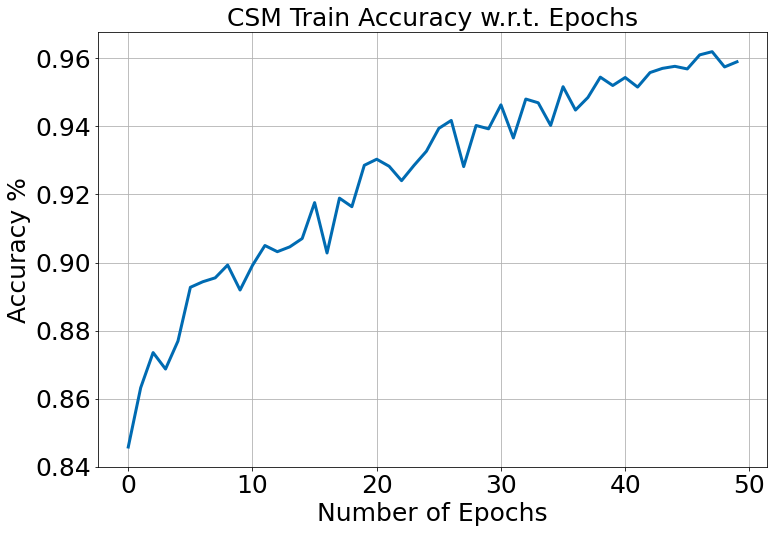

In [9]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'CSM Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

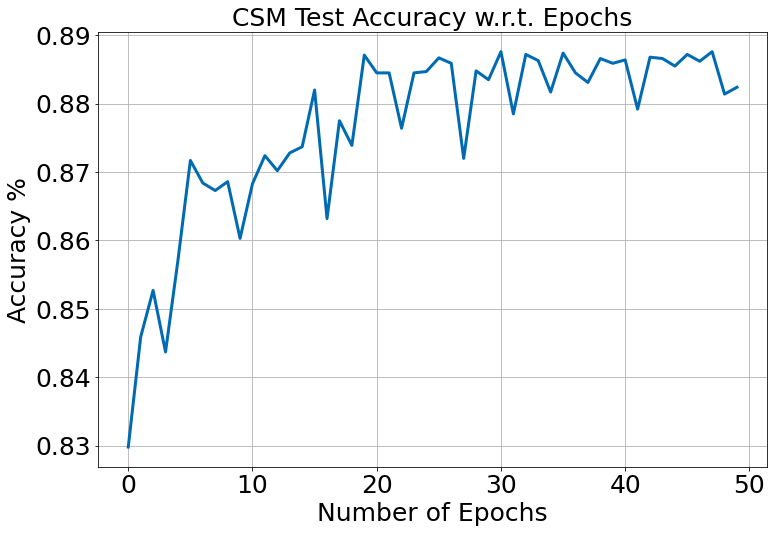

In [10]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'CSM Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)